# Предсказание рейтинга фильма

In [1]:
import nltk
from nltk.corpus import stopwords
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import numpy as np

https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews - dataset

In [4]:
data = pd.read_csv('IMDB Dataset.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
data.describe

<bound method NDFrame.describe of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>

## Стемминг

In [8]:
stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

In [9]:
def data_Stemmer(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stop])

In [10]:
data.review = data.review.apply(lambda x: data_Stemmer(x))

In [11]:
data.sentiment = data.sentiment.replace('positive', 1)
data.sentiment = data.sentiment.replace('negative', 0)

In [12]:
X = data.review
y = data.sentiment

In [27]:
y.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

## tf-idf преобразование

In [13]:
tf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=2, max_df=0.5, norm=None)

In [14]:
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.30, random_state=42)

In [29]:
ytr.value_counts()

0    17589
1    17411
Name: sentiment, dtype: int64

In [15]:
Xtr_tfidf = tf_vectorizer.fit_transform(Xtr)
Xval_tfidf = tf_vectorizer.transform(Xval)
Xtr_tfidf.shape, Xval_tfidf.shape

((35000, 487626), (15000, 487626))

In [32]:
ytr.value_counts()

0    17589
1    17411
Name: sentiment, dtype: int64

## Логистическая регрессия

In [17]:
logit_cv = LogisticRegressionCV(Cs=10, n_jobs=-1)
logit_cv.fit(Xtr_tfidf, ytr)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [33]:
print(accuracy_score(logit_cv.predict(Xtr_tfidf), ytr))
print(accuracy_score(logit_cv.predict(Xval_tfidf), yval))
print(classification_report(logit_cv.predict(Xval_tfidf), yval))

1.0
0.9054
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      7280
           1       0.92      0.90      0.91      7720

    accuracy                           0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000



Получили достаточно хорошее качество модели: `f1-score = 0.9 `

In [34]:
logit_cv.coef_.shape

(1, 487626)

## Визуализация коэффициентов

Text(0.5, 1.0, 'Negative')

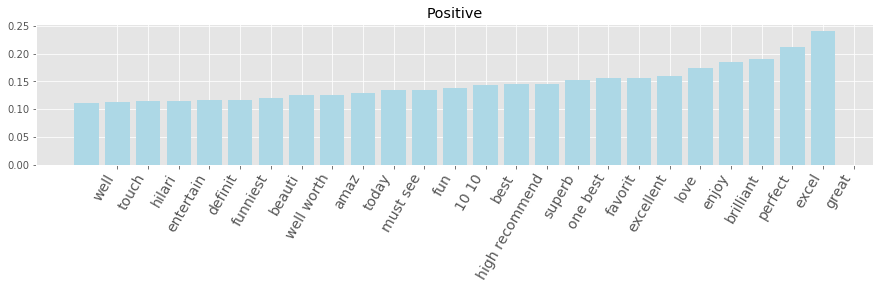

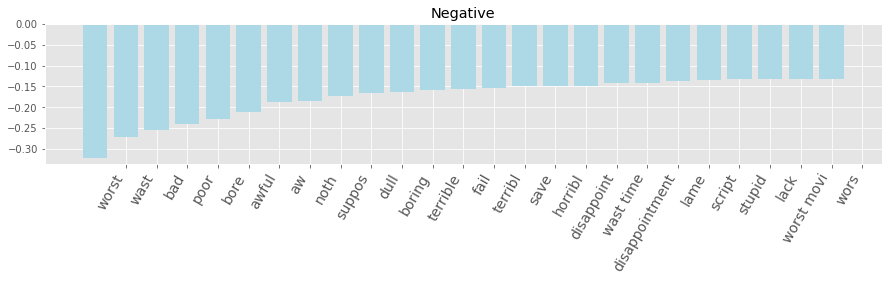

In [41]:
n_top_features=25
feature_names = tf_vectorizer.get_feature_names()
coef = logit_cv.coef_[0,:]
interesting_coefficients = np.argsort(coef)[-n_top_features:]
    
plt.figure(figsize=(15, 15))
plt.subplot(512)
colors = ["lightblue" for c in coef[interesting_coefficients]]
plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
feature_names = np.array(feature_names)
plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
plt.title('Positive')


interesting_coefficients = np.argsort(coef)[:n_top_features]
    
plt.figure(figsize=(15, 15))
plt.subplot(513)
colors = ["lightblue" for c in coef[interesting_coefficients]]
plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
feature_names = np.array(feature_names)
plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
plt.title('Negative')

